[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mobasserulHaque/Explainable-Techniques-II/blob/main/Assignment4_Explainable_Techniques_2.ipynb)





### Assignment 4 : Explainable Techniques II

**Mobasserul Haque**

## Attribution (Use of AI Citation)  

>The README was generated with assistance from an AI system (GPT-5 Thinking) and subsequently reviewed/edited by the author, who is responsible for the final content.

>Remaining parts of assignment LLMs have not been used



Our Goal is to Produce PDP, ICE, and ALE plots on a tabular model; examine feature correlations and discuss how correlation affects PDP vs. ALE.

### Dataset

- I have used the PRSA (Beijing) dataset contains hourly records of air quality and meteorological variables collected between 2010 and 2014.

- In this project, the goal is to predict PM2.5 concentration (µg/m³) using features such as temperature, pressure, dew point, wind speed, and temporal indicators like hour and month.

- This dataset is ideal for explainable modeling because it exhibits real-world nonlinear patterns and moderate correlations among features—conditions that make it especially useful for comparing how Partial Dependence Plots (PDP) and Accumulated Local Effects (ALE) respond to correlated predictors.


In [1]:
# --- Install required libraries (ALE from PyALE)
!pip install -q PyALE


import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

# Stats & correlation
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ALE (using PyALE)
from PyALE import ale

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility & style
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_theme(style="ticks")
plt.rcParams["figure.dpi"] = 120

def compute_vif(df_features: pd.DataFrame) -> pd.DataFrame:
    """Compute Variance Inflation Factors (VIF) for each numeric feature."""
    X = sm.add_constant(df_features)
    vifs = []
    for i in range(1, X.shape[1]):  # skip intercept
        vifs.append(variance_inflation_factor(X.values, i))
    return pd.DataFrame({"feature": df_features.columns, "VIF": vifs}).sort_values("VIF", ascending=False)



### 2. Data Loading, Cleaning, and Feature Engineering

We import the PRSA (Beijing) hourly dataset, parse datetimes, and create meteorological + temporal features (hour, month, day-of-week, season, weekend). We keep the target as PM2.5 (µg/m³) and handle missing values. Categorical wind direction is retained for modeling via one-hot encoding later.

In [2]:
# URL for PRSA Beijing PM2.5 dataset
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"

# Loading the dataset
try:
    df_raw = pd.read_csv(URL, na_values=["NA", "NaN", "null"])
except Exception as e:
    raise RuntimeError(f"Failed to load dataset from {URL}. Error: {e}")

# cleanup
# Expected columns: ['No','year','month','day','hour','pm2.5','DEWP','TEMP','PRES','cbwd','Iws','Is','Ir']
expected_cols = {"No","year","month","day","hour","pm2.5","DEWP","TEMP","PRES","cbwd","Iws","Is","Ir"}
missing_cols = expected_cols - set(df_raw.columns)
if missing_cols:
    print("Warning: Missing expected columns:", missing_cols)


df = df_raw.copy()
df["datetime"] = pd.to_datetime(df[["year","month","day","hour"]], errors="coerce")

# Target
target_col = "pm2.5"

# Temporal features
df["hour"] = df["hour"].astype(int)
df["month"] = df["month"].astype(int)
df["dow"] = df["datetime"].dt.dayofweek  # 0=Mon, 6=Sun
df["is_weekend"] = (df["dow"] >= 5).astype(int)

# Season
def season_of_month(m):
    if m in (12,1,2):
        return "winter"
    if m in (3,4,5):
        return "spring"
    if m in (6,7,8):
        return "summer"
    return "autumn"
df["season"] = df["month"].apply(season_of_month)

# Meteorological features (already numeric)
# TEMP (°C), DEWP (°C), PRES (hPa), Iws (cumulated wind speed), Is/Ir (hours of snow/rain in last hour)
num_cols = ["TEMP", "DEWP", "PRES", "Iws", "Is", "Ir", "hour", "month", "dow", "is_weekend"]

# Keep categorical wind direction for one-hot encoding
cat_cols = ["cbwd", "season"]


before = len(df)
df = df.dropna(subset=[target_col, "datetime"]).reset_index(drop=True)
after = len(df)

features_all = num_cols + cat_cols
df_model = df[features_all + [target_col]].dropna().reset_index(drop=True)

print("Raw shape:", df_raw.shape)
print("After dropping NA target/datetime:", (after, df_raw.shape[1]))
print("Modeling frame shape (after feature NA drop):", df_model.shape)

print("\nColumns:", df_model.columns.tolist())
print("\nMissing values (remaining):")
print(df_model.isna().sum().sort_values(ascending=False).head(10))

print("\nCategorical levels:")
for c in cat_cols:
    print(f"  {c}: {df_model[c].nunique()} levels -> {sorted(df_model[c].unique().tolist())[:10]}")

df_model.head(5)


Raw shape: (43824, 13)
After dropping NA target/datetime: (41757, 13)
Modeling frame shape (after feature NA drop): (41757, 13)

Columns: ['TEMP', 'DEWP', 'PRES', 'Iws', 'Is', 'Ir', 'hour', 'month', 'dow', 'is_weekend', 'cbwd', 'season', 'pm2.5']

Missing values (remaining):
TEMP          0
DEWP          0
PRES          0
Iws           0
Is            0
Ir            0
hour          0
month         0
dow           0
is_weekend    0
dtype: int64

Categorical levels:
  cbwd: 4 levels -> ['NE', 'NW', 'SE', 'cv']
  season: 4 levels -> ['autumn', 'spring', 'summer', 'winter']


,TEMP,DEWP,PRES,Iws,Is,Ir,hour,month,dow,is_weekend,cbwd,season,pm2.5
0,-4.0,-16,1020.0,1.79,0,0,0,1,5,1,SE,winter,129.0
1,-4.0,-15,1020.0,2.68,0,0,1,1,5,1,SE,winter,148.0
2,-5.0,-11,1021.0,3.57,0,0,2,1,5,1,SE,winter,159.0
3,-5.0,-7,1022.0,5.36,1,0,3,1,5,1,SE,winter,181.0
4,-5.0,-7,1022.0,6.25,2,0,4,1,5,1,SE,winter,138.0


We loaded the **PRSA (Beijing) Hourly Air Quality dataset** and constructed a clean modeling frame of **41,757 rows × 13 columns** after removing records with missing `pm2.5` values or invalid timestamps (from **43,824 raw rows**).

- **Target variable:** `pm2.5` (µg/m³) — fine particulate matter concentration  
- **Predictors:**
  - **Meteorological variables:** `TEMP`, `DEWP`, `PRES`, `Iws`, `Is`, `Ir`
  - **Temporal features:** `hour`, `month`, `dow` (day of week), `is_weekend`
  - **Categorical features:**  
    - `cbwd` — wind direction (`NE`, `NW`, `SE`, `cv`)  
    - `season` — (`spring`, `summer`, `autumn`, `winter`)

**Missing values:** None remain after cleaning, so no imputation is required.

This feature design captures both **meteorological factors** and **temporal dynamics** (time-of-day, seasonality), enabling non-linear effect analysis using methods such as **Partial Dependence Plots (PDP)**, **Individual Conditional Expectation (ICE)**, and **Accumulated Local Effects (ALE)**.


### 3. Train/Test Split, Encoding, Model Training, and Baseline Metrics

We’ll one-hot encode categorical features, keep numeric features as is, train a RandomForestRegressor, and report R²/RMSE. We also surface feature importances (mapped to transformed feature names) to choose targets for PDP/ICE/ALE.

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Define features/target
target_col = "pm2.5"

num_cols = ["TEMP", "DEWP", "PRES", "Iws", "Is", "Ir", "hour", "month", "dow", "is_weekend"]
cat_cols = ["cbwd", "season"]

X = df_model[num_cols + cat_cols].copy()
y = df_model[target_col].astype(float).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

# one-hot for categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

rf = RandomForestRegressor(
    n_estimators=600,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("rf", rf)
])

pipe.fit(X_train, y_train)

# --- Evaluate
y_pred = pipe.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test R²:  {r2:.3f}")
print(f"Test RMSE: {rmse:.3f} µg/m³")


# Extract transformed feature names & importances
# The underlying rf is the final step in the pipeline
rf_model = pipe.named_steps["rf"]
feat_names = pipe.named_steps["prep"].get_feature_names_out()

importances = pd.Series(rf_model.feature_importances_, index=feat_names).sort_values(ascending=False)

print("\nTop 15 features by RF impurity importance:")
display(importances.head(15))

# objects for later cells (PDP/ICE/ALE)
preprocessor = pipe.named_steps["prep"]
model = pipe.named_steps["rf"]
X_train_trans = preprocessor.transform(X_train)
X_test_trans = preprocessor.transform(X_test)
feat_names = preprocessor.get_feature_names_out()

pd.DataFrame({"y_test": y_test[:5].values, "y_pred": y_pred[:5]}).head()


Test R²:  0.690
Test RMSE: 51.943 µg/m³

Top 15 features by RF impurity importance:


,0
DEWP,0.260769
Iws,0.120224
season_winter,0.115611
PRES,0.109475
TEMP,0.094577
month,0.087845
hour,0.074562
dow,0.070449
cbwd_SE,0.025265
is_weekend,0.007466


,y_test,y_pred
0,215.0,155.202066
1,6.0,14.293429
2,280.0,237.641276
3,57.0,54.799247
4,50.0,65.391675


The Random Forest baseline achieves R² = 0.690 and RMSE = 51.94 µg/m³ on the test set. This is reasonable for hourly PM2.5 with noisy meteorology and time signals.

The top drivers by impurity importance are DEWP (dew point), Iws (cumulative wind speed), season_winter, PRES (pressure), and TEMP, followed by time signals (month, hour, day-of-week) and wind direction dummies.

Taken together, these suggest moisture/temperature/pressure set the dispersion/formation conditions, while wind and seasonality modulate accumulation and transport, time-of-day captures human activity cycles.

We’ll use these leading features for PDP/ICE/ALE and check how correlation among meteorological variables affects PDP vs. ALE interpretations.

### 4. Correlation analysis (Pearson, Spearman) & multicollinearity (VIF)

We’ll quantify correlation structure among numeric predictors and compute VIFs. This will help us judge when PDP might go off-manifold and when ALE is more reliable.

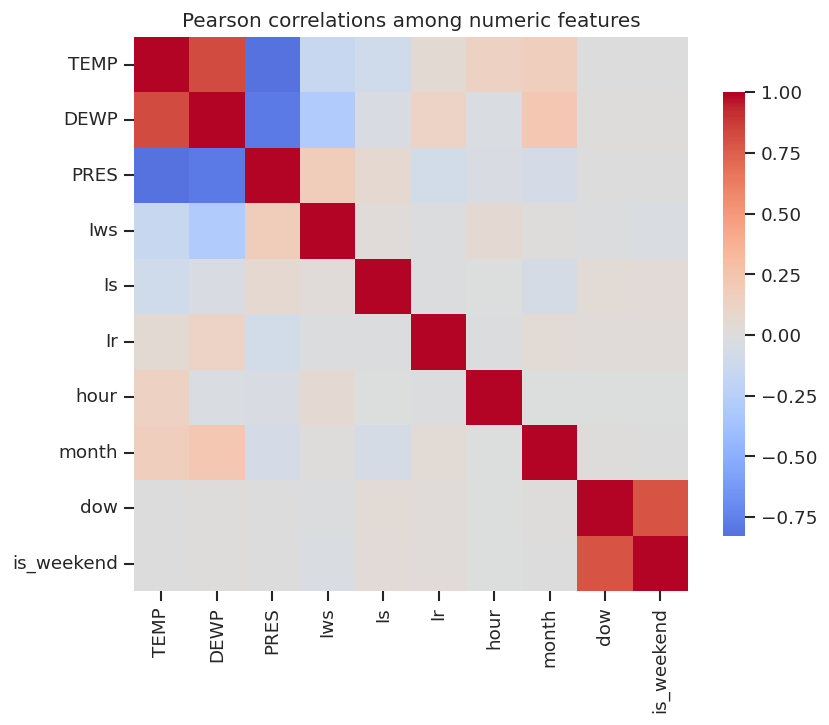

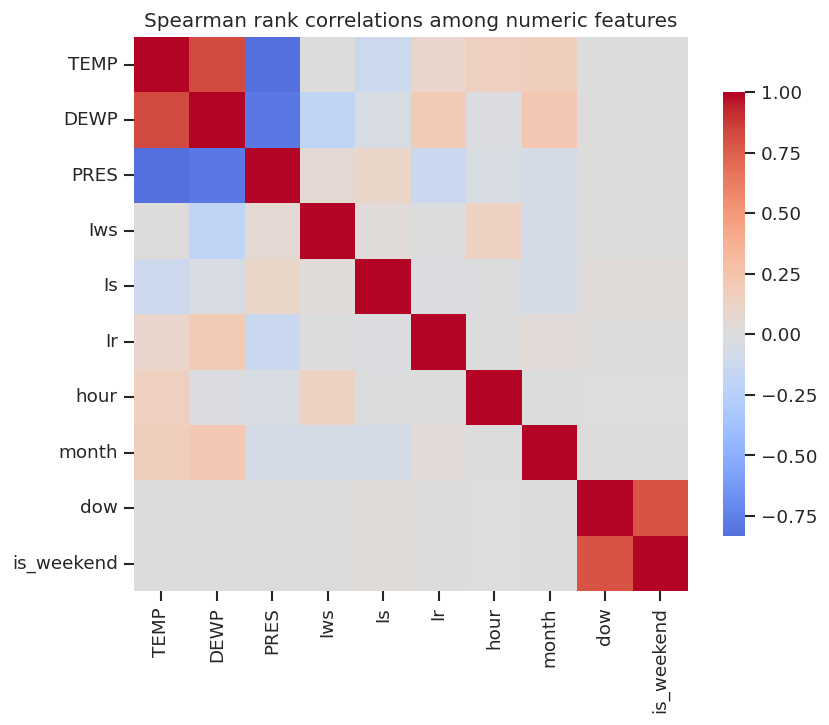

Top correlated numeric pairs (Pearson):


,feat_1,feat_2,abs_corr
0,TEMP,PRES,0.826903
1,PRES,TEMP,0.826903
2,DEWP,TEMP,0.823821
3,TEMP,DEWP,0.823821
4,is_weekend,dow,0.789155
5,dow,is_weekend,0.789155
6,DEWP,PRES,0.777722
7,PRES,DEWP,0.777722
8,DEWP,Iws,0.293106
9,Iws,DEWP,0.293106



Variance Inflation Factors (VIF):


,feature,VIF
0,TEMP,4.889565
1,DEWP,4.272012
2,PRES,3.652096
8,dow,2.653317
9,is_weekend,2.652849
3,Iws,1.142263
7,month,1.119616
6,hour,1.104171
5,Ir,1.030221
4,Is,1.024013


In [4]:
# Numeric columns only (including binary is_weekend)
num_cols = ["TEMP", "DEWP", "PRES", "Iws", "Is", "Ir", "hour", "month", "dow", "is_weekend"]

# Correlation matrices
corr_pearson = df_model[num_cols].corr(method="pearson")
corr_spearman = df_model[num_cols].corr(method="spearman")

fig, ax = plt.subplots(figsize=(7.5, 6))
sns.heatmap(corr_pearson, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title("Pearson correlations among numeric features")
plt.show()

fig, ax = plt.subplots(figsize=(7.5, 6))
sns.heatmap(corr_spearman, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title("Spearman rank correlations among numeric features")
plt.show()

# strongest absolute Pearson correlations
corr_abs = corr_pearson.abs().where(~np.eye(len(corr_pearson), dtype=bool))
top_pairs = (
    corr_abs.stack()
    .sort_values(ascending=False)
    .dropna()
    .reset_index()
)
top_pairs.columns = ["feat_1", "feat_2", "abs_corr"]
print("Top correlated numeric pairs (Pearson):")
display(top_pairs.head(10))

# VIF for multicollinearity
vif_df = compute_vif(df_model[num_cols])
print("\nVariance Inflation Factors (VIF):")
display(vif_df)

corr_pearson_vals = corr_pearson.copy()
vif_table = vif_df.copy()


### Correlation & Multicollinearity

Meteorological predictors show **moderate to strong correlations**:

- `TEMP`–`PRES` ≈ **−0.83**  
- `TEMP`–`DEWP` ≈ **+0.82**  
- `DEWP`–`PRES` ≈ **−0.78**  
- `is_weekend` is, as expected, **highly correlated** with its parent feature `dow` (day of week).

Variance Inflation Factors (**VIFs**) indicate **moderate multicollinearity**:  
`TEMP` ≈ 4.89, `DEWP` ≈ 4.27, `PRES` ≈ 3.65, and others ≤ ~2.7 — all **below common concern thresholds (5–10)**.


- **PDPs** (Partial Dependence Plots) average over the marginal distribution and can **drift off-manifold** when predictors are correlated (e.g., unrealistic `TEMP`–`PRES` combinations).  
- **ALE plots** (Accumulated Local Effects) are **more robust**, since they compute **local effects within observed data regions**.

#### What we could do next:

1. Present **PDP + ICE** for interpretability and visualization of global/local trends.  
2. Use **ALE** for highly correlated meteorological features (`TEMP`, `DEWP`, `PRES`).  
3. Include a **2D PDP** for the interacting pair **`TEMP × DEWP`** to visualize joint effects.


### 5. PDP + ICE for key drivers

Plots PDP (average) and ICE (individual) for DEWP, Iws, PRES, TEMP and a 2D PDP for TEMP×DEWP.

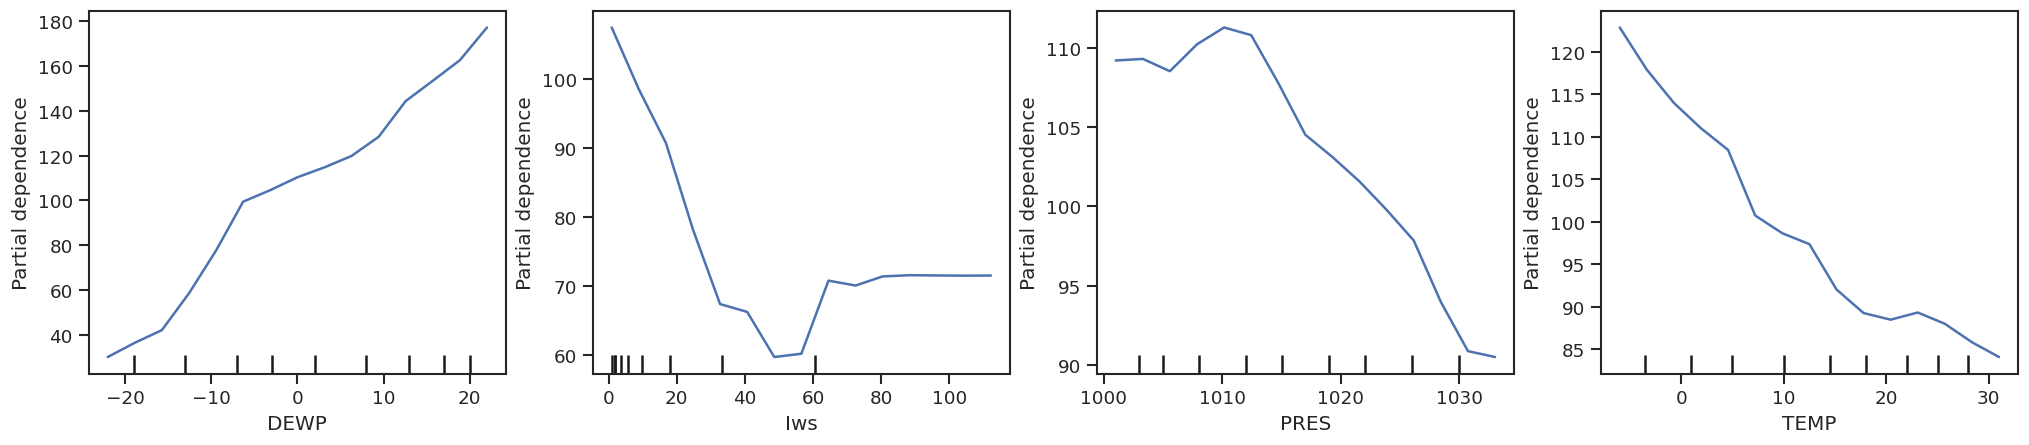

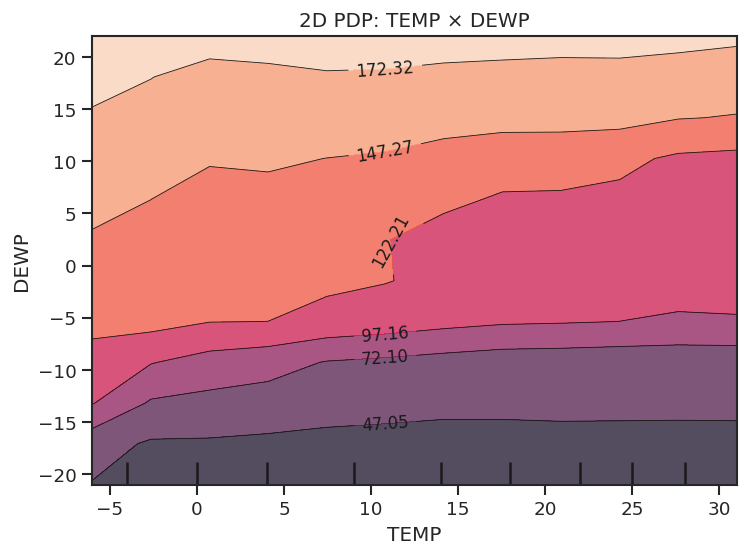

Done. Mode: FAST (PDP only)


In [7]:
# Plots 1D PDP (+ ICE when FAST=False) for DEWP, Iws, PRES, TEMP,
# plus a 2D PDP (average) for TEMP × DEWP.

FAST = True  # True = fast PDP-only; False = PDP + ICE

pdp_feats = ["DEWP", "Iws", "PRES", "TEMP"]
pair = ("TEMP", "DEWP")

GRID_1D = 15 if FAST else 40
GRID_2D = 12 if FAST else 25
ICE_SAMPLES = 800 if FAST else 2000

# Subsample training rows for plotting (avoids drawing thousands of ICE lines)
X_plot = X_train.sample(min(ICE_SAMPLES, len(X_train)), random_state=RANDOM_STATE)

# 1D PDP (FAST) or PDP+ICE
fig, axes = plt.subplots(1, len(pdp_feats), figsize=(4.2*len(pdp_feats), 3.6), constrained_layout=True)
if len(pdp_feats) == 1:
    axes = [axes]

for ax, feat in zip(axes, pdp_feats):
    try:
        if FAST:
            # Fast: PDP average only (no ICE), default brute method
            PartialDependenceDisplay.from_estimator(
                pipe, X_plot, [feat],
                kind="average",
                grid_resolution=GRID_1D,
                ax=ax
            )
            ax.set_title(f"PDP (avg): {feat}")
        else:
            # Full: PDP + ICE
            PartialDependenceDisplay.from_estimator(
                pipe, X_plot, [feat],
                kind="both",
                grid_resolution=GRID_1D,
                ax=ax
            )
            ax.set_title(f"PDP + ICE: {feat}")
    except TypeError:

        PartialDependenceDisplay.from_estimator(
            pipe, X_plot, [feat],
            grid_resolution=GRID_1D,
            ax=ax
        )
        ax.set_title(f"PDP: {feat}")
    ax.set_ylabel("partial dependence")
    ax.grid(True, alpha=0.3)

plt.show()

# 2D PDP (average) for TEMP × DEWP
try:
    PartialDependenceDisplay.from_estimator(
        pipe,
        X_train.sample(min(3000, len(X_train)), random_state=RANDOM_STATE),
        [list(pair)],
        kind="average",
        grid_resolution=GRID_2D
    )
    plt.title(f"2D PDP: {pair[0]} × {pair[1]}")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("2D PDP skipped:", e)

print("Done. Mode:", "FAST (PDP only)" if FAST else "FULL (PDP + ICE)")


#### Below are the PDP Findings — DEWP, Iws, PRES, TEMP

**DEWP (Dew Point)**

Shows a **strong monotonic increase** — as dew point rises (≈ −20 → +22 °C), predicted **PM2.5** increases almost linearly.  
This pattern aligns with the physics of **aerosol formation and accumulation** under humid and stable air conditions.

**Iws (Cumulative Wind Speed)**

Exhibits a **decreasing effect** up to roughly **50–60 units**, followed by a **slight flattening or rebound**.  
In general, higher wind speeds **disperse pollutants**, while the small rebound at extreme values likely reflects **interactions with seasonal or temporal conditions** and **diminishing marginal returns** at very high wind levels.

**PRES (Atmospheric Pressure)**

Displays a **mild hump** around **1008–1012 hPa**, then a **decline** at higher pressures.  
While stable high-pressure systems can **trap pollutants**, the **marginal effect** of pressure is **weaker** than that of dew point or wind speed.

**TEMP (Temperature)**

Shows a **monotonic decrease** — warmer hours predict **lower PM2.5**, after adjusting for other variables.  
Given correlations among `TEMP`, `DEWP`, and `PRES` (|ρ| ≈ 0.78–0.83), this pattern may be **partly confounded**, reflecting indirect meteorological relationships.

#### Below are the findings for **2D PDP: TEMP × DEWP**

A clear **vertical gradient** emerges with **DEWP** (dominant effect) and a gentler **negative gradient** with **TEMP**.  
Isopleths indicate that:
- At any temperature, **higher dew point -> higher PM2.5**.  
- **Increasing temperature** slightly **reduces PM2.5**.  

However, because `TEMP`, `DEWP`, and `PRES` are **correlated**, PDP may **average over unrealistic combinations**.  
To confirm stability and **avoid off-manifold effects**, we next validate these relationships using **ALE (Accumulated Local Effects)**, which is **restricted to observed data regions**.


**ICE-only Plot for key drivers**

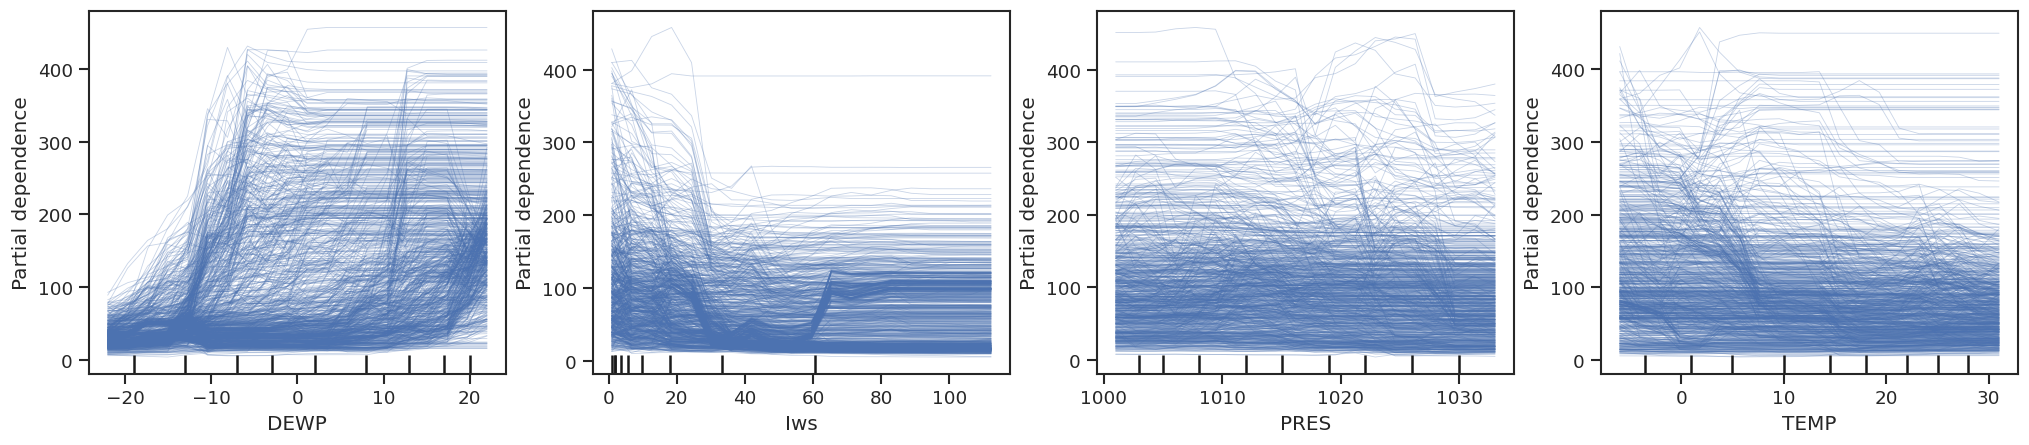

In [8]:
# ICE-only for key drivers

ICE_FEATS = ["DEWP", "Iws", "PRES", "TEMP"]
ICE_SAMPLES = 800
GRID_1D = 20

# Subsample to keep the number of ICE lines manageable
X_ice = X_train.sample(min(ICE_SAMPLES, len(X_train)), random_state=RANDOM_STATE)

fig, axes = plt.subplots(1, len(ICE_FEATS), figsize=(4.2*len(ICE_FEATS), 3.6), constrained_layout=True)
if len(ICE_FEATS) == 1:
    axes = [axes]

for ax, feat in zip(axes, ICE_FEATS):
    try:
        PartialDependenceDisplay.from_estimator(
            pipe, X_ice, [feat],
            kind="individual",          # ICE
            grid_resolution=GRID_1D,
            ax=ax
        )
        ax.set_title(f"ICE: {feat}  (n={len(X_ice)})")
    except TypeError:

        PartialDependenceDisplay.from_estimator(
            pipe, X_ice, [feat],
            grid_resolution=GRID_1D,
            ax=ax
        )
        ax.set_title(f"PDP (ICE unsupported): {feat}")
    ax.set_ylabel("prediction")
    ax.grid(True, alpha=0.3)

plt.show()




**DEWP (Dew Point)**

Most ICE curves **trend upward**, reaffirming the **positive relationship** between dew point and **PM2.5**.  
The noticeable **fan-out** (wider spread at higher dew points) indicates **context-dependent effects** — for instance, the impact is stronger **in winter** or **under specific pressure regimes**.

**Iws (Cumulative Wind Speed)**

Lines generally **decline** as wind speed increases, reflecting **pollution dispersion**.  
A small **kink or rebound around ~60** suggests potential **interactions with season or hour**, or possibly **data sparsity** at high wind speeds.

**PRES (Atmospheric Pressure)**

ICE lines are **mostly flat** with **gentle curvature**; some subsets **rise and then fall**, consistent with **stable high-pressure systems** that temporarily **trap pollutants** before conditions shift.

**TEMP (Temperature)**

Many ICE lines **decrease with temperature**, supporting the inverse relationship seen in PDPs.  
However, the **wide vertical offsets** across lines imply **strong interactions** with **humidity (DEWP)** and **pressure (PRES)** — i.e., the temperature effect depends heavily on concurrent meteorological states.

ICE plots reveal **substantial heterogeneity** — effects vary notably across individual observations.  
To account for correlated predictors (`TEMP`–`DEWP`–`PRES`) and ensure **on-manifold, unbiased estimates**, we will validate these findings using **ALE (Accumulated Local Effects)**, which provides **locally averaged** interpretations grounded in observed data regions.


### 6) Plot ALE for the same features

INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.


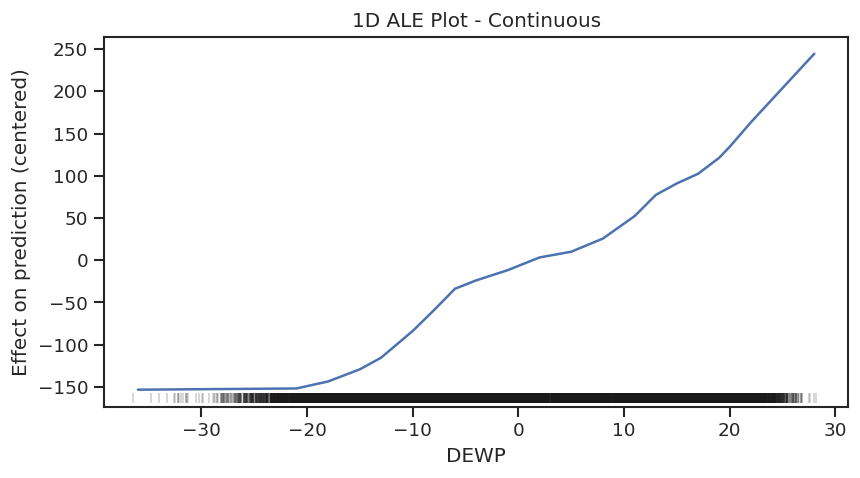

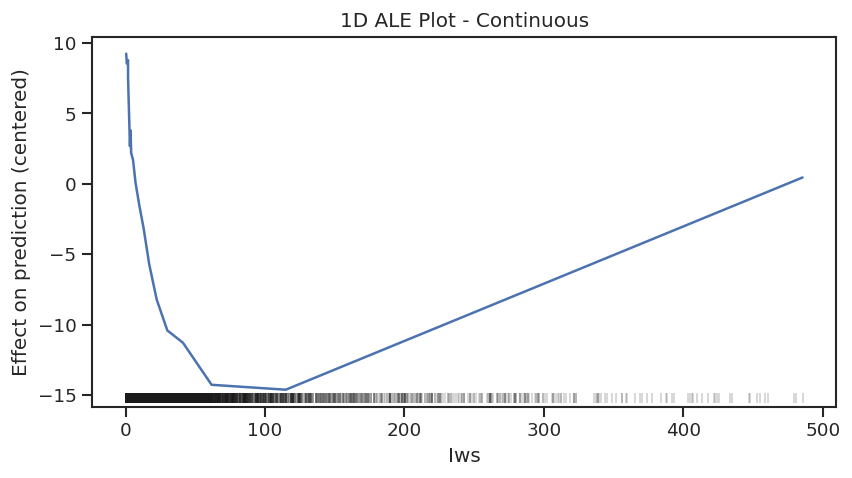

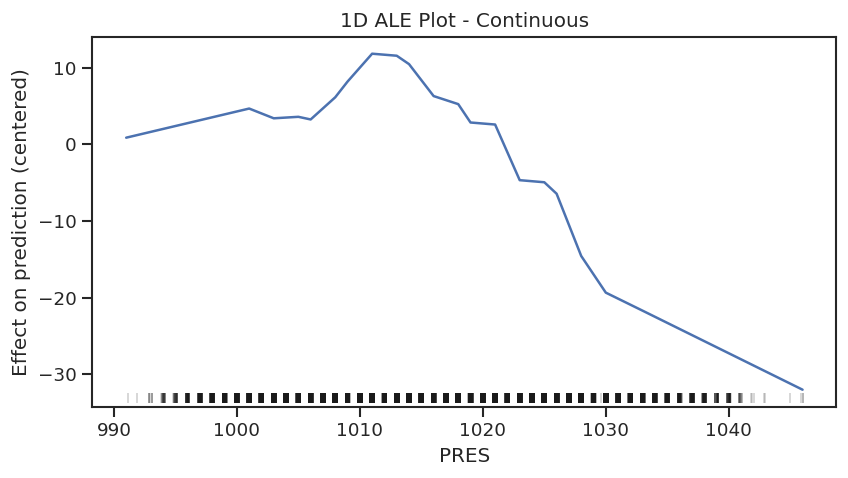

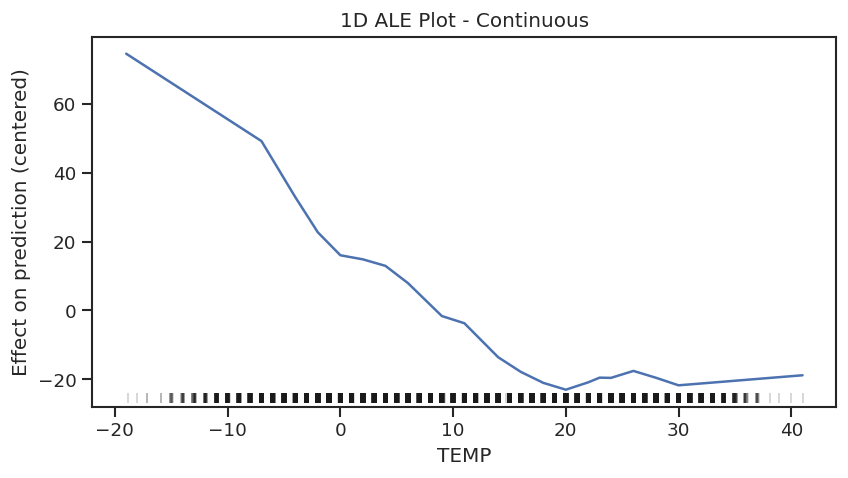

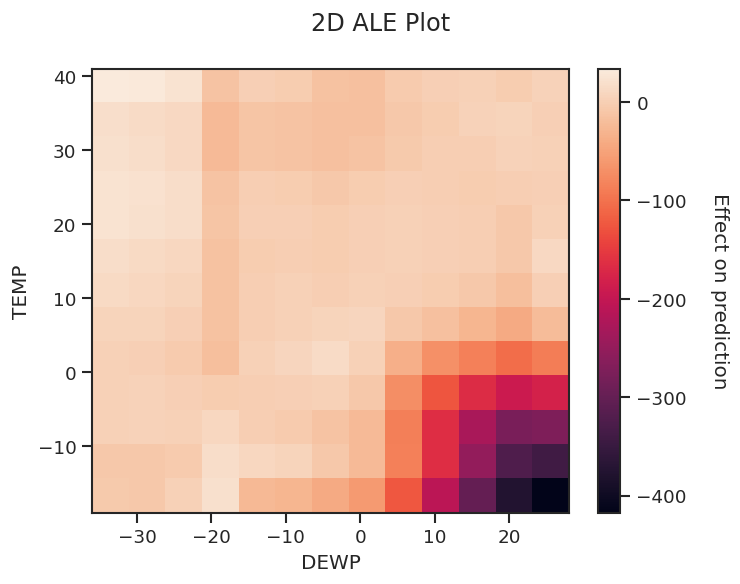

In [12]:
# 1D ALE for: DEWP, Iws, PRES, TEMP
# 2D ALE for: TEMP × DEWP

from PyALE import ale

ALE_SAMPLE = 10000
GRID_1D    = 20
GRID_2D    = 12

X_ale = X_train.sample(min(ALE_SAMPLE, len(X_train)), random_state=RANDOM_STATE).copy()

def ale_1d(feature, grid=GRID_1D):
    """Robust 1D ALE across PyALE versions."""
    last_err = None
    for kwargs in (
        {"feature": [feature], "grid_size": grid, "include_CI": False},
        {"feature": [feature], "grid_size": grid},
        {"feature": feature,   "grid_size": grid},
    ):
        try:
            ale(X=X_ale, model=pipe, **kwargs)  # pass the pipeline object
            return
        except TypeError as e:
            last_err = e
    print(f"1D ALE failed for {feature}: {last_err}")

def ale_2d(f1, f2, grid=GRID_2D):
    """Robust 2D ALE across PyALE versions."""
    last_err = None
    for kwargs in (
        {"feature": [f1, f2], "grid_size": grid, "include_CI": False},
        {"feature": [f1, f2], "grid_size": grid},
    ):
        try:
            ale(X=X_ale, model=pipe, **kwargs)
            return
        except TypeError as e:
            last_err = e
    print(f"2D ALE failed for ({f1}, {f2}): {last_err}")

# 1D ALE
for f in ["DEWP", "Iws", "PRES", "TEMP"]:
    ale_1d(f, grid=GRID_1D)

# 2D ALE: TEMP × DEWP ---
ale_2d("TEMP", "DEWP", grid=GRID_2D)



- DEWP (Dew Point):  
  Shows a **strong positive local effect** that **accelerates above ~0–10 °C**.  
  Moving from very dry (−20 °C) to humid (+25 °C) air increases predicted **PM2.5** by **~200 µg/m³ (centered)**.  
  This reinforces the PDP trend and aligns with **humidity-driven secondary aerosol formation** and **reduced dispersion** under moist, stable air conditions.

- Iws (Cumulative Wind):
  Displays a **sharp negative effect** up to ~60–100, then **levels off** toward zero.  
  ALE suggests wind **reduces PM2.5** but the benefit **saturates at high speeds**.  
  Sparse rug marks on the right tail indicate **limited data**, so extreme values should be interpreted cautiously.

- PRES (Atmospheric Pressure):  
  Peaks locally around **1010–1012 hPa** and **declines thereafter**.  
  In this dataset, higher pressure corresponds to **cleaner, northerly air masses**, producing **negative effects** relative to the centered mean.

- TEMP (Temperature):
  Shows a **clear negative effect** from ~−15 °C to ~20 °C, then **plateaus**.  
  Warmer conditions **reduce predicted PM2.5**, but the **benefit diminishes** once boundary-layer mixing becomes strong at higher temperatures.

### **2D ALE (TEMP × DEWP)**

The **dominant gradient** runs along **DEWP (moisture)**, with the **strongest PM2.5 increases** in the **cold–humid corner** — classic **winter haze conditions**.  
Color contours show **relative contrasts**, not absolute signs:  
- At any temperature, **higher dew point → higher PM2.5**.  
- Increasing temperature at fixed dew point has a **smaller mitigating effect**.

**Comparison ALE and PDP**

| Feature | PDP Behavior | ALE Correction | Interpretation |
|----------|---------------|----------------|----------------|
| **Iws (Wind)** | Slight rebound around ~60 | Monotone decrease → plateau | PDP rebound likely off-support artifact; ALE stays realistic. |
| **TEMP (Temperature)** | Steady decline | Decline then plateau | ALE shows diminishing returns at high temperature (well-mixed air). |
| **PRES (Pressure)** | Broad hump | Sharper peak (~1010–1012 hPa) | ALE captures **local regime change** rather than a global slope. |

**Why ALE is Preferable Here**

We observe **strong correlations** among meteorological variables:  
- `TEMP–DEWP` ≈ **+0.82**  
- `TEMP–PRES` ≈ **−0.83**  
- VIFs: `TEMP` ≈ 4.9, `DEWP` ≈ 4.3, `PRES` ≈ 3.7  

Under this **multicollinearity**, PDPs can average predictions at **unrealistic (off-manifold)** combinations (e.g., **very high TEMP and high DEWP**), causing spurious shape artifacts such as the Iws rebound.  

**ALE** computes **local differences within observed bins**, remaining **on-manifold** and thus yielding **more reliable marginal effects** for correlated meteorological predictors.

### **Key Takeaways**

- **Moisture dominates:** Dew point is the **most influential continuous driver** of PM2.5; managing humidity-related sources is critical.  
- **Wind helps but saturates:** Dispersion benefits **flatten beyond ~60–100** (dataset units); extreme wind offers limited added gain.  
- **Cold–humid episodes are worst:** The **2D ALE** pinpoints the **cold + humid regime** as the **highest pollution zone** — a signature of winter haze.  
- **Temperature’s role is conditional:** Warming **reduces PM2.5** only up to a point; effects depend strongly on **DEWP** and **PRES** interactions.


### Discussion: PDP vs. ALE and the role of correlation

Agreement: For DEWP and TEMP, PDP and ALE both show strong, smooth trends (DEWP increases, TEMP decreases). This consistency suggests the effects are genuine rather than artifacts.

Differences: For Iws, PDP hinted at a small rebound near ~60, while ALE shows a monotone decrease then plateau—more plausible given physics (dispersion) and consistent with on-manifold estimation. For PRES, ALE sharpens a local peak (1010–1012 hPa) then decline; PDP smooths this into a broader hump.

Why it happens: Meteorology variables are correlated (TEMP–DEWP ≈ 0.82; TEMP–PRES ≈ −0.83; DEWP–PRES ≈ −0.78). PDP averages over the marginal distribution and can evaluate the model at unrealistic feature combos. ALE computes local differences within bins that contain data, so it’s more robust to correlation and better captures regime-specific effects.

Limitations and threats to validity

- Correlated predictors: Despite ALE’s robustness, strong correlations (TEMP–DEWP–PRES) still complicate causal interpretations. Effects are associational.

- Data coverage: Tails (very high wind, extreme dew point/temperature) are sparse; interpret ALE/PDP there cautiously (check rug marks).

- Model class: A single Random Forest was used; different models (e.g., gradient boosting) may learn slightly different local shapes.

- Temporal dependence: We treated hours i.i.d.; adding lag features or station identifiers could improve fidelity.

### Conclusions

Moisture dominates: Higher DEWP strongly increases predicted PM2.5, especially from ~0 °C upwards.

Wind disperses then saturates: Iws has a clear negative effect with diminishing returns at high wind.

Pressure regime matters: A local peak near ~1010–1012 hPa suggests stable episodes that elevate PM2.5, followed by declines at higher pressures.

Temperature reduces risk up to a point: TEMP lowers predictions but plateaus at higher values once the boundary layer is likely well mixed.

>In the presence of correlated features, ALE provides more reliable on-manifold effects than PDP; ICE revealed meaningful heterogeneity, indicating interactions with season/time.